In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 환경 설정 및 데이터 준비

## 1.1 라이브러리 임포트

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, GRU, concatenate,
    GlobalAveragePooling1D,
    Add, Activation, LayerNormalization,
    MultiHeadAttention
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

## 1.2 데이터 로드 헬퍼 함수 정의

In [3]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [4]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [5]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [6]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

## 1.3 데이터 로드 및 검증 세트 분리

In [7]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)
X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [8]:
# 3D 데이터를 스케일링하기 위해 (samples, timesteps, features) -> (samples * timesteps, features) 2D로 변환
n_features = X_train.shape[2]
X_train_2d = X_train.reshape(-1, n_features)
X_val_2d = X_val.reshape(-1, n_features)
testX_2d = testX.reshape(-1, n_features)

In [9]:
# Train 데이터 기준으로 스케일러 피팅
scaler = StandardScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_val_scaled_2d = scaler.transform(X_val_2d)
testX_scaled_2d = scaler.transform(testX_2d)

In [10]:
# 다시 3D (samples, timesteps, features) 형태로 복원
X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_val_scaled = X_val_scaled_2d.reshape(X_val.shape)
testX_scaled = testX_scaled_2d.reshape(testX.shape)

In [11]:
print("Scaling completed. Scaled Train Shape:", X_train_scaled.shape)

Scaling completed. Scaled Train Shape: (5881, 128, 9)


# 2. 모델 정의

## 2.1 모델 파라미터 설정

In [12]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [13]:
# 공통 학습 파라미터
EPOCHS = 100
BATCH_SIZE = 64

# 입력 형태 정의
input_shape = (n_timesteps, n_features)

## 2.2 Transformer 모델 정의

In [14]:
def transformer_encoder_block(inputs, head_size, num_heads, ff_dim, dropout=0, reg=l2(1e-4)):
    """Transformer Encoder 블록"""
    # 1. Attention and Normalization
    x = LayerNormalization()(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x) # Self-attention
    x = Dropout(dropout)(x)
    res = Add()([x, inputs]) # Skip connection

    # 2. Feed Forward and Normalization
    x = LayerNormalization()(res)
    # FFN은 1D Conv로 구현
    x = Conv1D(filters=ff_dim, kernel_size=1, activation='relu', kernel_regularizer=reg)(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1, kernel_regularizer=reg)(x)
    x = Add()([x, res]) # Skip connection
    return x

In [15]:
def build_transformer_model():
    reg = l2(1e-4)
    inputs = Input(shape=input_shape)

    # 1. Stem: 입력 피처(9)를 모델의 임베딩 차원(예: 64)으로 투영
    x = Conv1D(64, 3, padding='same', kernel_regularizer=reg)(inputs)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)

    # 2. Transformer Encoder 스택
    # (head_size * num_heads)는 임베딩 차원(64)과 일치하거나 관련있게 설정
    x = transformer_encoder_block(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3, reg=reg)
    x = transformer_encoder_block(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3, reg=reg)
    x = transformer_encoder_block(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3, reg=reg)

    # 3. Classifier
    x = GlobalAveragePooling1D()(x) # (batch, 64)
    x = Dense(256, activation='relu', kernel_regularizer=reg)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(n_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=5e-4)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# 3. 모델 빌드

In [16]:
model_transformer = build_transformer_model()

In [17]:
model_transformer.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 64)   │      1,792 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 64)   │        128 │ conv1d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 64)   │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ activation[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 64)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128)  │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 64)   │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 64)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 64)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 128)  │      8,320 │ layer_normalizat

 Total params: 269,702 (1.03 MB)

 Trainable params: 269,702 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

# 4. 모델 학습

In [18]:
# Callbacks 정의
# 15 Epochs 동안 val_loss가 개선되지 않으면 학습 중단 및 최적 가중치 복원
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# 5 Epochs 동안 val_loss가 개선되지 않으면 학습률을 0.2배로 감소
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

In [19]:
history = model_transformer.fit(
    X_train_scaled,
    y_train_one_hot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val_one_hot),
    verbose=2,
    callbacks=callbacks
)

Epoch 1/100
92/92 - 50s - 549ms/step - accuracy: 0.8131 - loss: 0.5535 - val_accuracy: 0.9218 - val_loss: 0.2389 - learning_rate: 5.0000e-04
Epoch 2/100
92/92 - 2s - 22ms/step - accuracy: 0.9340 - loss: 0.2291 - val_accuracy: 0.9354 - val_loss: 0.1884 - learning_rate: 5.0000e-04
Epoch 3/100
92/92 - 2s - 20ms/step - accuracy: 0.9486 - loss: 0.1872 - val_accuracy: 0.9490 - val_loss: 0.1728 - learning_rate: 5.0000e-04
Epoch 4/100
92/92 - 2s - 19ms/step - accuracy: 0.9543 - loss: 0.1731 - val_accuracy: 0.9449 - val_loss: 0.1818 - learning_rate: 5.0000e-04
Epoch 5/100
92/92 - 2s - 19ms/step - accuracy: 0.9520 - loss: 0.1720 - val_accuracy: 0.9524 - val_loss: 0.1680 - learning_rate: 5.0000e-04
Epoch 6/100
92/92 - 2s - 20ms/step - accuracy: 0.9585 - loss: 0.1592 - val_accuracy: 0.9538 - val_loss: 0.1524 - learning_rate: 5.0000e-04
Epoch 7/100
92/92 - 2s - 20ms/step - accuracy: 0.9587 - loss: 0.1564 - val_accuracy: 0.9558 - val_loss: 0.1491 - learning_rate: 5.0000e-04
Epoch 8/100
92/92 - 2s - 

# 4. 결과 분석 및 평가

## 4.1 학습 과정 시각화 (Loss & Accuracy)

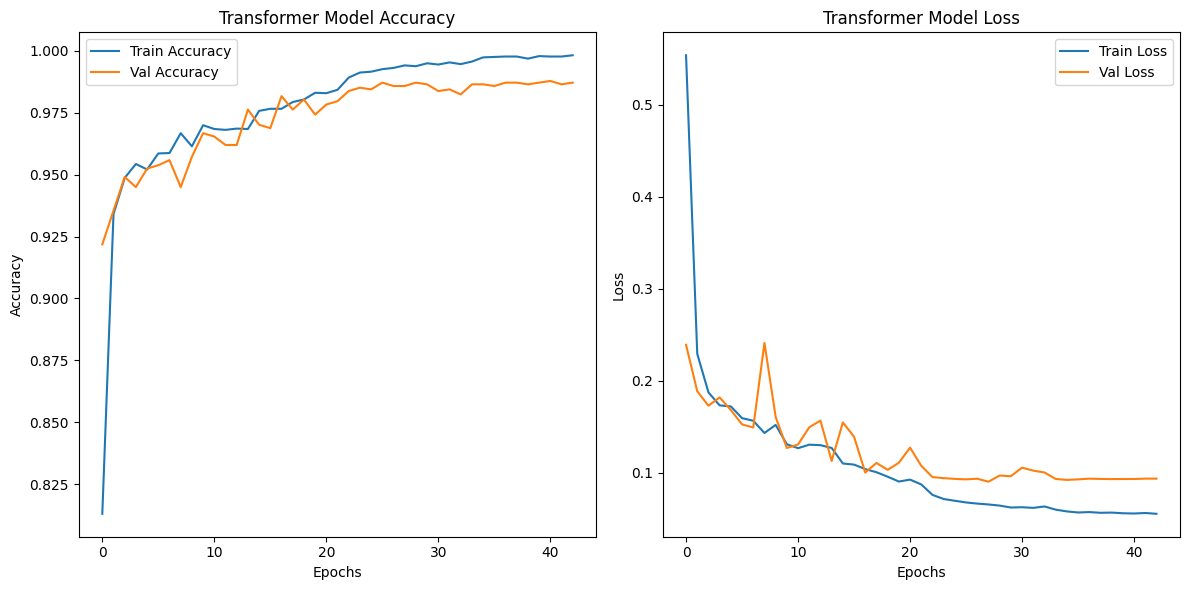

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Transformer Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Transformer Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## 4.2 테스트 세트 평가 (Confusion Matrix)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Accuracy: 0.9281

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       496
           1       0.99      0.92      0.96       471
           2       0.89      1.00      0.94       420
           3       0.87      0.82      0.85       491
           4       0.86      0.89      0.87       532
           5       0.99      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



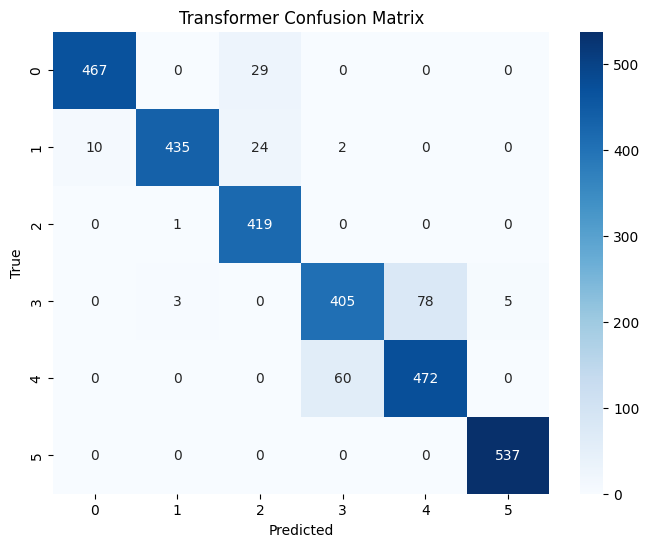

In [21]:
pred_probs = model_transformer.predict(testX_scaled)
pred_classes = np.argmax(pred_probs, axis=-1)

print(f"Accuracy: {accuracy_score(testy, pred_classes):.4f}")
print("\nClassification Report:")
print(classification_report(testy, pred_classes))

cm = confusion_matrix(testy, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Transformer Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()